In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/fruits-dataset
# unzip the file


 96% 289M/300M [00:02<00:00, 99.3MB/s]
100% 300M/300M [00:02<00:00, 112MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fruits-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive')
data_dir = "/content/drive/MyDrive/fruits dataset/dataset"
data_dir = pathlib.Path(data_dir)

Mounted at /content/gdrive


In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import pandas as pd
import seaborn as sn
import tensorflow as tf
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]



train_path ='/content/dataset/Train/Train'
valid_path = '/content/dataset/Validation/Validation'
test_path = '/content/dataset/Test/Test'

In [ ]:
folders = glob('/content/dataset/Train/Train/*')

In [ ]:
folders

['/content/dataset/Train/Train/Elephant Apple',
 '/content/dataset/Train/Train/Wood Apple',
 '/content/dataset/Train/Train/Tamarind',
 '/content/dataset/Train/Train/Carambola',
 '/content/dataset/Train/Train/Emblica',
 '/content/dataset/Train/Train/Sapodilla',
 '/content/dataset/Train/Train/Burmese Grape',
 '/content/dataset/Train/Train/Bilimbi']

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dataset = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

valid_dataset = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_dataset = ImageDataGenerator(rescale = 1./255)

In [ ]:
training_set = train_dataset.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

validation_set = valid_dataset.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_dataset.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical')

Found 1960 images belonging to 8 classes.
Found 640 images belonging to 8 classes.
Found 640 images belonging to 8 classes.


### Hybrid model mobileNet + vgg19 approach 1

In [ ]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Concatenate
from keras.applications import MobileNet, VGG19
from keras.optimizers import Adam

# Define image size
IMAGE_SIZE = (224, 224)

# Number of classes (replace with your actual number of classes)
num_classes = len(folders)

# MobileNet model
mobile = MobileNet(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)
for layer in mobile.layers:
    layer.trainable = False

# VGG19 model
vgg = VGG19(input_shape=IMAGE_SIZE + (3,), weights='imagenet', include_top=False)
for layer in vgg.layers:
    layer.trainable = False

# Flatten the outputs
x_mobile = Flatten()(mobile.output)
x_vgg = Flatten()(vgg.output)

# Concatenate the outputs
x = Concatenate()([x_mobile, x_vgg])

# Dense layers for fine-tuning
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# Output layer
predictions = Dense(num_classes, activation='softmax')(x)

# Create the hybrid model
model = Model(inputs=[mobile.input, vgg.input], outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']      

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
def custom_generator(generator):
    while True:
        # Get the batch of data from the original generator
        batch = generator.next()

        # Assuming your generator returns a tuple (inputs, targets)
        inputs, targets = batch

        # For a multi-input model, create a tuple of inputs
        # In this example, assuming your model has two inputs
        # Modify this part based on your actual model architecture
        inputs_tuple = ([inputs, inputs], targets)

        yield inputs_tuple

# Create custom generators
custom_training_generator = custom_generator(training_set)
custom_validation_generator = custom_generator(validation_set)

# Fit the model using fit_generator
r = model.fit_generator(
    generator=custom_training_generator,
    validation_data=custom_validation_generator,
    epochs=20,
    steps_per_epoch=len(training_set),
    validation_steps=len(validation_set)
)


<ipython-input-45-a38f969838f4>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


62/62 [==============================] - 85s 1s/step - loss: 4.7362 - accuracy: 0.8005 - val_loss: 0.5539 - val_accuracy: 0.9344
Epoch 2/20
62/62 [==============================] - 74s 1s/step - loss: 0.2399 - accuracy: 0.9694 - val_loss: 0.1655 - val_accuracy: 0.9750
Epoch 3/20
62/62 [==============================] - 73s 1s/step - loss: 0.1375 - accuracy: 0.9796 - val_loss: 0.3308 - val_accuracy: 0.9625
Epoch 4/20
62/62 [==============================] - 73s 1s/step - loss: 0.0910 - accuracy: 0.9842 - val_loss: 0.2667 - val_accuracy: 0.9688
Epoch 5/20
62/62 [==============================] - 94s 2s/step - loss: 0.1186 - accuracy: 0.9816 - val_loss: 0.2996 - val_accuracy: 0.9656
Epoch 6/20
62/62 [==============================] - 73s 1s/step - loss: 0.1195 - accuracy: 0.9857 - val_loss: 0.2375 - val_accuracy: 0.9797
Epoch 7/20
62/62 [==============================] - 73s 1s/step - loss: 0.0136 - accuracy: 0.9964 - val_loss: 0.1092 - val_accuracy: 0.9859
Epoch 8/20
62/62 [=============

In [ ]:
# Assuming you have a test set generator named test_set
# and you've already trained your model using the fit_generator method

# Create a custom test generator
custom_test_generator = custom_generator(test_set)

# Evaluate the model on the test set
test_results = model.evaluate_generator(
    generator=custom_test_generator,
    steps=len(test_set)
)

# Print the test results
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])


<ipython-input-46-4a9fd869f002>:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_results = model.evaluate_generator(


Test Loss: 0.08265327662229538
Test Accuracy: 0.9906250238418579


In [ ]:
# Assuming test_set is an instance of DirectoryIterator
# If not, you may need to modify this based on your actual data structure
test_images, test_labels = test_set.next()

# Generate predictions
y_pred = model.predict([test_images, test_images])

# Convert predictions to class labels
y_pred_classes = y_pred.argmax(axis=-1)

# Get true class labels
y_true = test_labels.argmax(axis=-1)

# Compute individual metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Display metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


1/1 [==============================] - 0s 89ms/step
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


### Hybrid model mobileNet+VGG19 (approach 2)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, VGG19
from tensorflow.keras.utils import to_categorical

# Number of classes
num_classes = 8

# Input shape for the models
input_shape = (224, 224, 3)  # adjust this based on your data

# Load MobileNet without top (fully connected layers)
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Load VGG19 without top (fully connected layers)
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze layers in both models
for layer in base_mobilenet.layers:
    layer.trainable = False

for layer in base_vgg19.layers:
    layer.trainable = False

# Create a hybrid model
input_tensor = Input(shape=input_shape)

# Extract features from MobileNet
mobilenet_features = base_mobilenet(input_tensor)

# Extract features from VGG19
vgg19_features = base_vgg19(input_tensor)

# Concatenate the features
merged_features = concatenate([mobilenet_features, vgg19_features], axis=-1)

# Global average pooling to reduce spatial dimensions
global_avg_pooling = GlobalAveragePooling2D()(merged_features)

# Fully connected layer for classification
output = Dense(num_classes, activation='softmax')(global_avg_pooling)  # Dense layer worked as a output layer for my model

# Create the final model
hybrid_model = Model(inputs=input_tensor, outputs=output)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
hybrid_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_10[0][0]']            
 onal)                                                                                            
                                                                                                  
 vgg19 (Functional)          (None, 7, 7, 512)            2002438   ['input_10[0][0]']            
                                                          4                                       
                                                                                            

In [ ]:
model = hybrid_model
r = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/15
62/62 [==============================] - 69s 1s/step - loss: 0.7653 - accuracy: 0.8000 - val_loss: 0.2792 - val_accuracy: 0.9656
Epoch 2/15
62/62 [==============================] - 68s 1s/step - loss: 0.1914 - accuracy: 0.9684 - val_loss: 0.1548 - val_accuracy: 0.9781
Epoch 3/15
62/62 [==============================] - 87s 1s/step - loss: 0.1140 - accuracy: 0.9837 - val_loss: 0.1149 - val_accuracy: 0.9844
Epoch 4/15
62/62 [==============================] - 68s 1s/step - loss: 0.0839 - accuracy: 0.9867 - val_loss: 0.0935 - val_accuracy: 0.9875
Epoch 5/15
62/62 [==============================] - 71s 1s/step - loss: 0.0637 - accuracy: 0.9918 - val_loss: 0.0847 - val_accuracy: 0.9859
Epoch 6/15
62/62 [==============================] - 68s 1s/step - loss: 0.0521 - accuracy: 0.9939 - val_loss: 0.0775 - val_accuracy: 0.9875
Epoch 7/15
62/62 [==============================] - 75s 1s/step - loss: 0.0439 - accuracy: 0.9939 - val_loss: 0.0629 - val_accuracy: 0.9875
Epoch 8/15
62/62 [==

In [ ]:
def curve():
   plt.figure(figsize=(14, 7))
   plt.subplot(1, 2, 1)
   plt.plot(history.history['loss'], label='Training Loss')
   plt.plot(history.history['val_loss'], label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training & Validation Loss')


   plt.subplot(1, 2, 2)
   plt.plot(history.history['accuracy'], label='Training Accuracy')
   plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training & Validation Accuracy')

   plt.show()

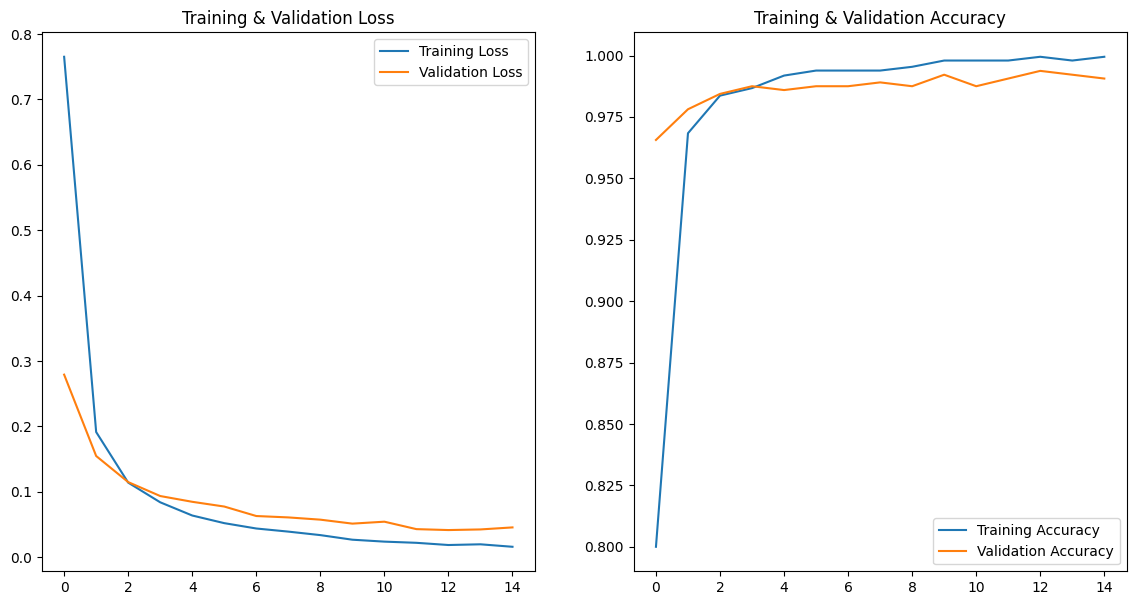

In [ ]:
history = r
curve()

In [ ]:
test_loss,test_acc = model.evaluate(test_set, verbose=2)
print('\nTest accuracy:', test_acc)

640/640 - 55s - loss: 0.0189 - accuracy: 0.9969 - 55s/epoch - 86ms/step

Test accuracy: 0.996874988079071


Give the image path :/content/dataset/Test/Test/Bilimbi/101-removebg-preview.png


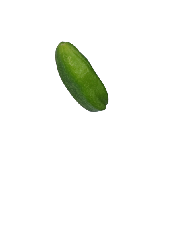

1/1 [==============================] - 0s 91ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Probability ->
0
Bilimbi


In [ ]:
import cv2
predicted_Output=['Bilimbi','Burmese Grape','Carambola','Elephant Apple','Emblica','Sapodilla','Tamarind','Wood Apple']
input_image_path = input("Give the image path :")
img = cv2.imread(input_image_path)
img = cv2.resize(img,(224,224))
img_array = np.array(img)
img_array = img_array.reshape(1,224,224,3)

from tensorflow.keras.preprocessing import image
plt.figure(figsize=(4,3))
img = image.load_img(input_image_path)
plt.imshow(img,interpolation='nearest')
plt.axis('off')
plt.show()

a=model.predict(img_array)
print("Probability ->")

indices = a.argmax()
print(indices)
print(predicted_Output[indices])

In [ ]:
model.save('/content/gdrive/MyDrive/fruits dataset/mobileNet+vgg19_99.68.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Give the image path :/content/dataset/Test/Test/Wood Apple/10-removebg-preview.png


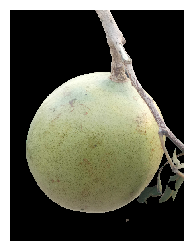

1/1 [==============================] - 0s 114ms/step
7
Wood Apple


In [ ]:
import cv2
predicted_Output=['Bilimbi','Burmese Grape','Carambola','Elephant Apple','Emblica','Sapodilla','Tamarind','Wood Apple']
input_image_path = input("Give the image path :")
img = cv2.imread(input_image_path)
img = cv2.resize(img,(224,224))
img_array = np.array(img)
img_array = img_array.reshape(1,224,224,3)

from tensorflow.keras.preprocessing import image
plt.figure(figsize=(4,3))
img = image.load_img(input_image_path)
plt.imshow(img,interpolation='nearest')
plt.axis('off')
plt.show()

a=model.predict(img_array)
indices = a.argmax()
print(indices)
print(predicted_Output[indices])

Give the image path :/content/dataset/Test/Test/Tamarind/105-removebg-preview.png


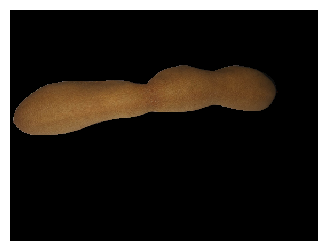

1/1 [==============================] - 0s 87ms/step
6
Tamarind


In [ ]:
import cv2
predicted_Output=['Bilimbi','Burmese Grape','Carambola','Elephant Apple','Emblica','Sapodilla','Tamarind','Wood Apple']
input_image_path = input("Give the image path :")
img = cv2.imread(input_image_path)
img = cv2.resize(img,(224,224))
img_array = np.array(img)
img_array = img_array.reshape(1,224,224,3)

from tensorflow.keras.preprocessing import image
plt.figure(figsize=(4,3))
img = image.load_img(input_image_path)
plt.imshow(img,interpolation='nearest')
plt.axis('off')
plt.show()

a=model.predict(img_array)
indices = a.argmax()
print(indices)
print(predicted_Output[indices])

Hybrid (mobileNet+vgg19) CM

In [ ]:
from keras.models import load_model

# Provide the path to the saved model file
model_path = '/content/drive/MyDrive/model/mobileNet+vgg19_99.68.h5'

# Load the model
model = load_model(model_path)

In [ ]:
nb_samples = len(test_set)
print(nb_samples)

640


1/1 [==============================] - 0s 29ms/step


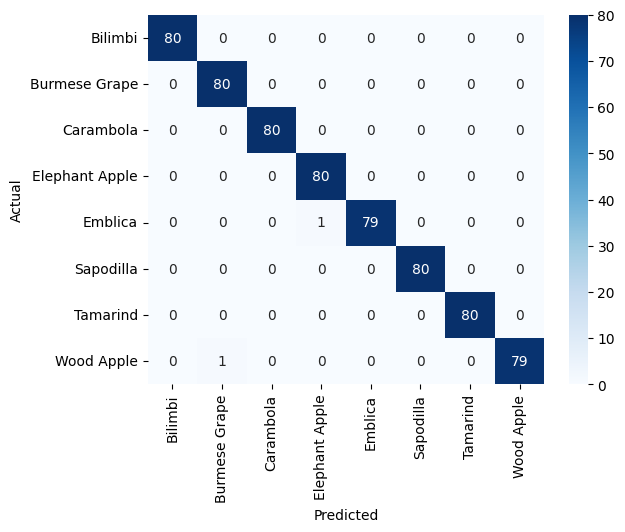

test accuracy : 99.6875


In [ ]:
# model = tf.keras.models.load_model("model_VGG19.h5")
filenames = test_set.filenames
#nb_samples = len(test_set)
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
from sklearn.metrics import classification_report
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]
class_report = classification_report(actual_class, predicted_class, target_names=list(test_set.class_indices.keys()))

# Print classification report
print(class_report)

1/1 [==============================] - 0s 25ms/step
                precision    recall  f1-score   support

       Bilimbi       1.00      1.00      1.00        80
 Burmese Grape       0.99      1.00      0.99        80
     Carambola       1.00      1.00      1.00        80
Elephant Apple       0.99      1.00      0.99        80
       Emblica       1.00      0.99      0.99        80
     Sapodilla       1.00      1.00      1.00        80
      Tamarind       1.00      1.00      1.00        80
    Wood Apple       1.00      0.99      0.99        80

      accuracy                           1.00       640
     macro avg       1.00      1.00      1.00       640
  weighted avg       1.00      1.00      1.00       640



### MobileNet+inceptionV3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet, InceptionV3
from tensorflow.keras.utils import to_categorical

# Number of classes
num_classes = 8

# Input shape for the models
input_shape = (224, 224, 3)  # adjust this based on your data

# Load MobileNet without top (fully connected layers)
base_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Load InceptionV3 without top (fully connected layers)
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze layers in both models
for layer in base_mobilenet.layers:
    layer.trainable = False

for layer in base_inception.layers:
    layer.trainable = False

# Create a hybrid model
input_tensor = Input(shape=input_shape)

# Extract features from MobileNet with GlobalAveragePooling2D
mobilenet_features = GlobalAveragePooling2D()(base_mobilenet(input_tensor))

# Extract features from InceptionV3 with GlobalAveragePooling2D
inception_features = GlobalAveragePooling2D()(base_inception(input_tensor))

# Concatenate the features
merged_features = concatenate([mobilenet_features, inception_features], axis=-1)

# Fully connected layer for classification
output = Dense(num_classes, activation='softmax')(merged_features)

# Create the final model
hybrid_model = Model(inputs=input_tensor, outputs=output)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
hybrid_model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_25 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_25[0][0]']            
 onal)                                                                                            
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_25[0][0]']            
                                                          4                                       
                                                                                            

In [ ]:
model = hybrid_model
r = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


62/62 [==============================] - 80s 1s/step - loss: 0.4213 - accuracy: 0.8755 - val_loss: 0.1223 - val_accuracy: 0.9656
Epoch 2/15
62/62 [==============================] - 68s 1s/step - loss: 0.0789 - accuracy: 0.9827 - val_loss: 0.0716 - val_accuracy: 0.9891
Epoch 3/15
62/62 [==============================] - 65s 1s/step - loss: 0.0461 - accuracy: 0.9898 - val_loss: 0.0579 - val_accuracy: 0.9859
Epoch 4/15
62/62 [==============================] - 65s 1s/step - loss: 0.0340 - accuracy: 0.9959 - val_loss: 0.0583 - val_accuracy: 0.9859
Epoch 5/15
62/62 [==============================] - 67s 1s/step - loss: 0.0236 - accuracy: 0.9969 - val_loss: 0.0441 - val_accuracy: 0.9891
Epoch 6/15
62/62 [==============================] - 67s 1s/step - loss: 0.0188 - accuracy: 0.9985 - val_loss: 0.0447 - val_accuracy: 0.9875
Epoch 7/15
62/62 [==============================] - 75s 1s/step - loss: 0.0165 - accuracy: 0.9980 - val_loss: 0.0309 - val_accuracy: 0.9984
Epoch 8/15
62/62 [=============

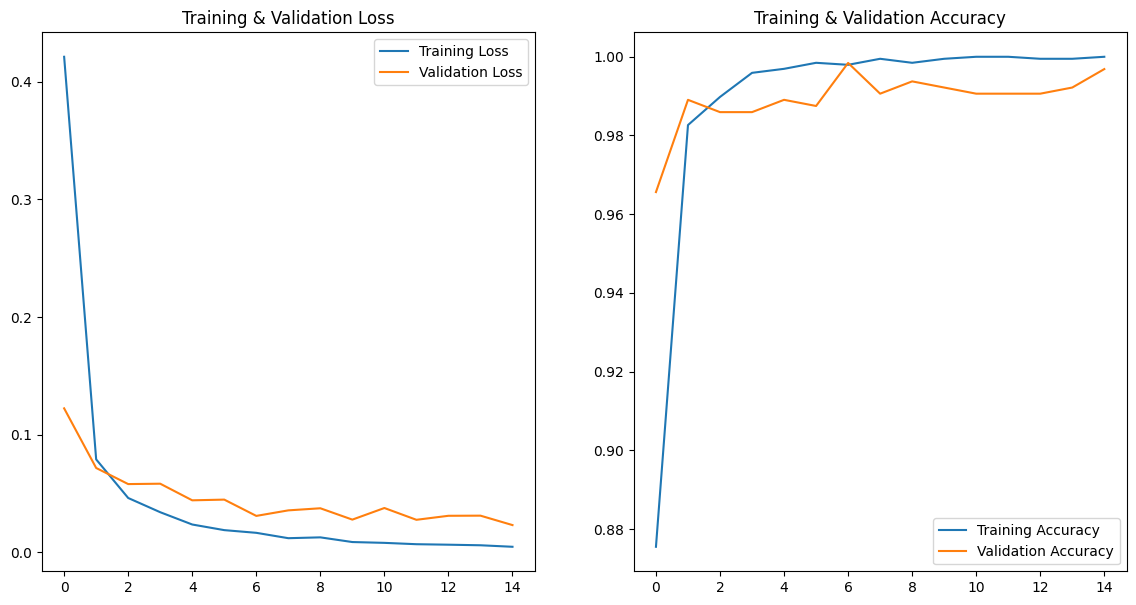

In [ ]:
def curve():
   plt.figure(figsize=(14, 7))
   plt.subplot(1, 2, 1)
   plt.plot(history.history['loss'], label='Training Loss')
   plt.plot(history.history['val_loss'], label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training & Validation Loss')


   plt.subplot(1, 2, 2)
   plt.plot(history.history['accuracy'], label='Training Accuracy')
   plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training & Validation Accuracy')

   plt.show()

history = r
curve()

In [ ]:
test_loss,test_acc = model.evaluate(test_set, verbose=2)
print('\nTest accuracy:', test_acc)

640/640 - 201s - loss: 0.0127 - accuracy: 0.9953 - 201s/epoch - 313ms/step

Test accuracy: 0.995312511920929


In [ ]:
model.save('/content/drive/MyDrive/fruits dataset/mobileNet+inceptionv3_9953.h5')

Hybrid (mobileNet+inceptionv3) CM

In [ ]:
from keras.models import load_model

# Provide the path to the saved model file
model_path = '/content/drive/MyDrive/model/mobileNet+inceptionv3_9953.h5'

# Load the model
model = load_model(model_path)

In [ ]:
nb_samples = len(test_set)
print(nb_samples)

640


1/1 [==============================] - 0s 52ms/step


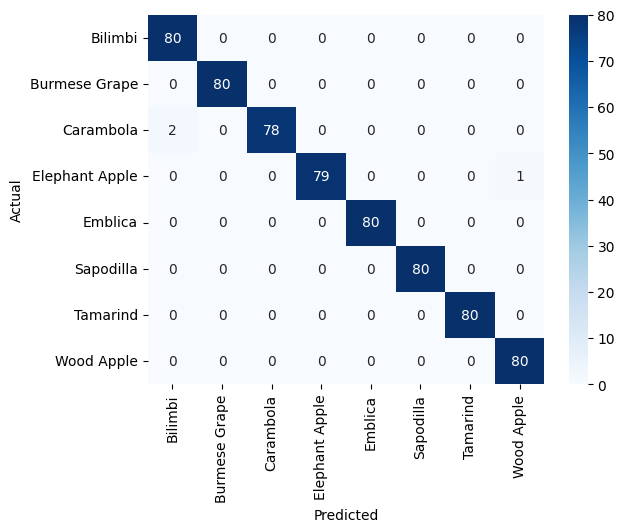

test accuracy : 99.53125


In [ ]:
# model = tf.keras.models.load_model("model_VGG19.h5")
filenames = test_set.filenames
#nb_samples = len(test_set)
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))


In [ ]:
from sklearn.metrics import classification_report
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]
class_report = classification_report(actual_class, predicted_class, target_names=list(test_set.class_indices.keys()))

# Print classification report
print(class_report)

1/1 [==============================] - 0s 31ms/step
                precision    recall  f1-score   support

       Bilimbi       0.98      1.00      0.99        80
 Burmese Grape       1.00      1.00      1.00        80
     Carambola       1.00      0.97      0.99        80
Elephant Apple       1.00      0.99      0.99        80
       Emblica       1.00      1.00      1.00        80
     Sapodilla       1.00      1.00      1.00        80
      Tamarind       1.00      1.00      1.00        80
    Wood Apple       0.99      1.00      0.99        80

      accuracy                           1.00       640
     macro avg       1.00      1.00      1.00       640
  weighted avg       1.00      1.00      1.00       640



### vgg19 + InceptionV3

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG19, InceptionV3
from tensorflow.keras.utils import to_categorical

# Number of classes
num_classes = 8

# Input shape for the models
input_shape = (224, 224, 3)  # adjust this based on your data

# Load VGG19 without top (fully connected layers)
base_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)

# Load InceptionV3 without top (fully connected layers)
base_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze layers in both models
for layer in base_vgg19.layers:
    layer.trainable = False

for layer in base_inception.layers:
    layer.trainable = False

# Create a hybrid model
input_tensor = Input(shape=input_shape)

# Extract features from VGG19 with GlobalAveragePooling2D
vgg19_features = GlobalAveragePooling2D()(base_vgg19(input_tensor))

# Extract features from InceptionV3 with GlobalAveragePooling2D
inception_features = GlobalAveragePooling2D()(base_inception(input_tensor))

# Concatenate the features
merged_features = concatenate([vgg19_features, inception_features], axis=-1)

# Fully connected layer for classification
output = Dense(num_classes, activation='softmax')(merged_features)

# Create the final model
hybrid_model = Model(inputs=input_tensor, outputs=output)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
hybrid_model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg19 (Functional)          (None, 7, 7, 512)            2002438   ['input_31[0][0]']            
                                                          4                                       
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_31[0][0]']            
                                                          4                                       
                                                                                            

In [ ]:
model = hybrid_model
r = model.fit(
  training_set,
  validation_data=validation_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(validation_set)
)

Epoch 1/15
62/62 [==============================] - 101s 2s/step - loss: 0.6626 - accuracy: 0.8026 - val_loss: 0.2647 - val_accuracy: 0.9297
Epoch 2/15
62/62 [==============================] - 83s 1s/step - loss: 0.1630 - accuracy: 0.9628 - val_loss: 0.1878 - val_accuracy: 0.9531
Epoch 3/15
62/62 [==============================] - 84s 1s/step - loss: 0.1146 - accuracy: 0.9714 - val_loss: 0.1794 - val_accuracy: 0.9391
Epoch 4/15
62/62 [==============================] - 83s 1s/step - loss: 0.0927 - accuracy: 0.9770 - val_loss: 0.0967 - val_accuracy: 0.9766
Epoch 5/15
62/62 [==============================] - 83s 1s/step - loss: 0.0669 - accuracy: 0.9872 - val_loss: 0.0877 - val_accuracy: 0.9781
Epoch 6/15
62/62 [==============================] - 90s 1s/step - loss: 0.0552 - accuracy: 0.9888 - val_loss: 0.0764 - val_accuracy: 0.9828
Epoch 7/15
62/62 [==============================] - 88s 1s/step - loss: 0.0488 - accuracy: 0.9878 - val_loss: 0.0609 - val_accuracy: 0.9937
Epoch 8/15
62/62 [=

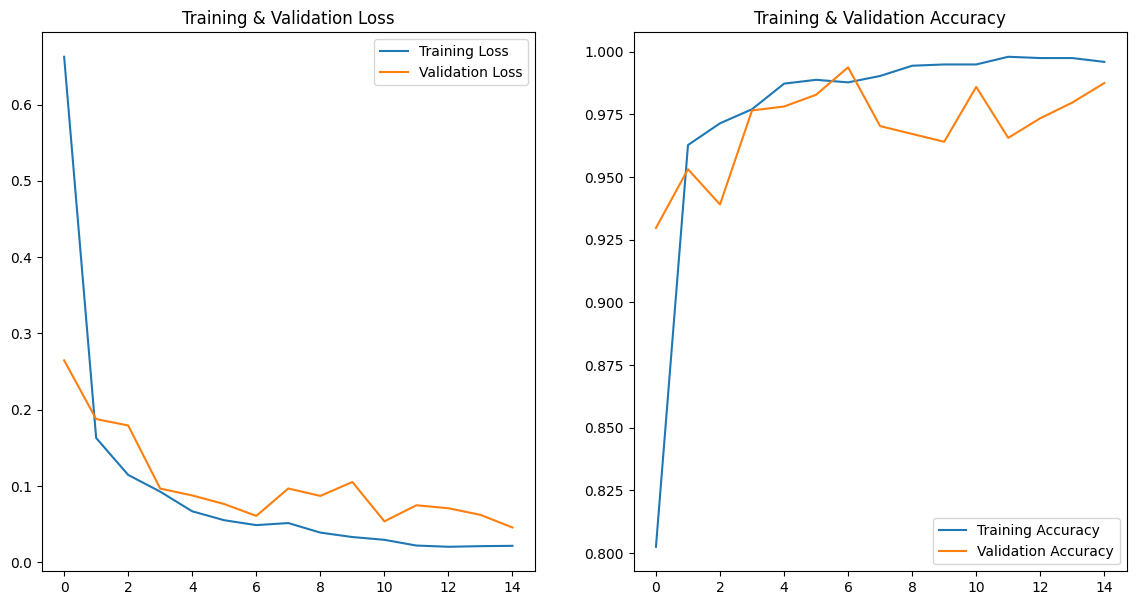

In [ ]:
def curve():
   plt.figure(figsize=(14, 7))
   plt.subplot(1, 2, 1)
   plt.plot(history.history['loss'], label='Training Loss')
   plt.plot(history.history['val_loss'], label='Validation Loss')
   plt.legend(loc='upper right')
   plt.title('Training & Validation Loss')


   plt.subplot(1, 2, 2)
   plt.plot(history.history['accuracy'], label='Training Accuracy')
   plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
   plt.legend(loc='lower right')
   plt.title('Training & Validation Accuracy')

   plt.show()

history = r
curve()

In [ ]:
test_loss,test_acc = model.evaluate(test_set, verbose=2)
print('\nTest accuracy:', test_acc)

640/640 - 136s - loss: 0.0426 - accuracy: 0.9922 - 136s/epoch - 212ms/step

Test accuracy: 0.9921875


In [ ]:
model.save('/content/drive/MyDrive/fruits dataset/vgg19+inceptionv3_9953.h5')

Hybrid (vgg19+inceptionv3) CM

In [ ]:
from keras.models import load_model

# Provide the path to the saved model file
model_path = '/content/drive/MyDrive/model/vgg19+inceptionv3_9953.h5'

# Load the model
model = load_model(model_path)

In [ ]:
nb_samples = len(test_set)
print(nb_samples)

640


1/1 [==============================] - 0s 56ms/step


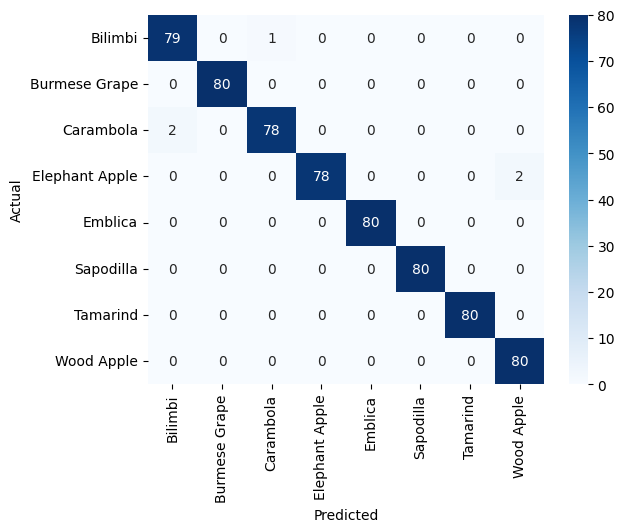

test accuracy : 99.21875


In [ ]:
# model = tf.keras.models.load_model("model_VGG19.h5")
filenames = test_set.filenames
#nb_samples = len(test_set)
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]


out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show()
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [ ]:
from sklearn.metrics import classification_report
y_prob=[]
y_act=[]
test_set.reset()
for _ in range(nb_samples):
  X_test,Y_test = test_set.next()
  y_prob.append(model.predict(X_test))
  y_act.append(Y_test)

predicted_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(training_set.class_indices.keys())[i.argmax()] for i in y_act]
class_report = classification_report(actual_class, predicted_class, target_names=list(test_set.class_indices.keys()))

# Print classification report
print(class_report)

1/1 [==============================] - 0s 28ms/step
                precision    recall  f1-score   support

       Bilimbi       0.98      0.99      0.98        80
 Burmese Grape       1.00      1.00      1.00        80
     Carambola       0.99      0.97      0.98        80
Elephant Apple       1.00      0.97      0.99        80
       Emblica       1.00      1.00      1.00        80
     Sapodilla       1.00      1.00      1.00        80
      Tamarind       1.00      1.00      1.00        80
    Wood Apple       0.98      1.00      0.99        80

      accuracy                           0.99       640
     macro avg       0.99      0.99      0.99       640
  weighted avg       0.99      0.99      0.99       640

